In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
%matplotlib inline

In [3]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
#輸入資料集、電影類型，回傳平均評分的分數
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1).reindex(avg_genre_votes_per_user.index)
        
    genre_ratings.columns = column_names
    return genre_ratings

In [6]:
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Adventure'], ['avg_romance_rating', 'avg_adventure_rating'])
genre_ratings.head()

,avg_romance_rating,avg_adventure_rating
userId,,
1,4.31,4.39
2,4.50,4.17
3,0.50,2.73
4,3.38,3.66
5,3.09,3.25


In [7]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_adventure_rating'] > score_limit_2)) | ((genre_ratings['avg_adventure_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

In [8]:
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  142


,userId,avg_romance_rating,avg_adventure_rating
0,3,0.50,2.73
1,7,2.65,3.31
2,12,4.57,3.00
3,19,2.68,2.82
4,26,3.00,2.67


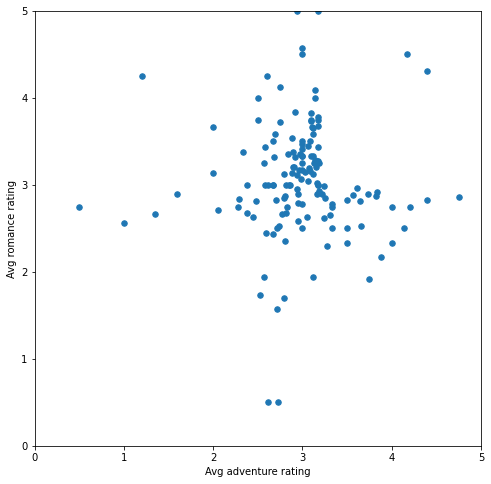

In [9]:
#將上述142筆資料進行視覺化分析
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_adventure_rating'],'Avg adventure rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

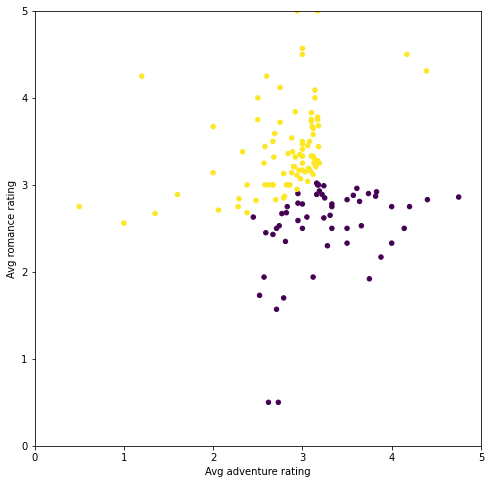

In [10]:
#進行分群
from sklearn.cluster import KMeans

#抓取訓練資料集
X = biased_dataset[['avg_adventure_rating','avg_romance_rating']].values

#K值為2
kmeans_1 = KMeans(n_clusters=2)
predictions = kmeans_1.fit_predict(X)

#畫圖
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg adventure rating')
    ax.set_ylabel('Avg romance rating')
    
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_adventure_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)
    
# Plot
draw_clusters(biased_dataset, predictions)

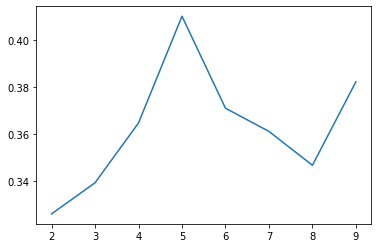

In [11]:
silhouette_avg = []
for i in range(2,10):
    kmeans_fit = KMeans(n_clusters = i).fit(X)
    silhouette_avg.append(silhouette_score(X, kmeans_fit.labels_))
    
plt.plot(range(2,10), silhouette_avg)

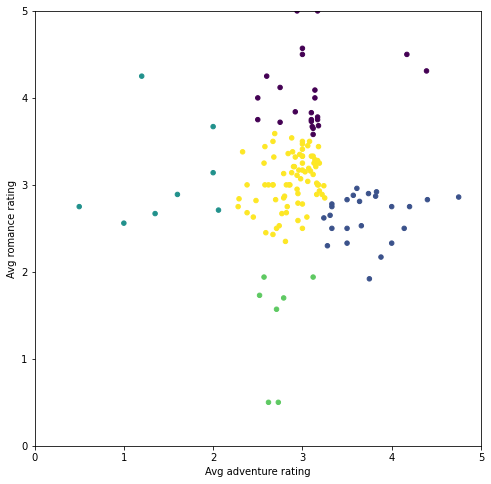

In [14]:
#K值為5
kmeans_5 = KMeans(n_clusters=5)
predictions_5 = kmeans_5.fit_predict(X)

draw_clusters(biased_dataset, predictions_5)